# Problem Statement:
# What features are most correlated with the prescence and degree of neuronal spontaneous activity?

> Chronic pain is a devasting condition that affects up to 1/5 of adults in the world. Though many analgesic (pain-relief) drugs have been developed, none so far prove to be effective in either longetivity, potency for pain relief. There are many possible explanations for this lack of drug penetrance but one that could be explored comparatively faster would be to re-assess the evidence that have formulated the general consensus of how chronic pain persists in patients. The major hallmark of persistent pain is the presence of spontaneous neuronal activity in those that peripheral nerve trauma. In general, it is believed that after nerve injury, there is generation/increase in the levels of spontaneous activity that can sensitise the nervous system in such ways that the body feels pain despite the initial injury wound is healed. Unfortunately, much of the seminal work on spontaneous activity were conducted more than 20 years ago, when reporting standards were not as stringent. One problem that arises as a result is that many fibre types are either unclearly stated by the authors. Additionally, there are some difficulties in differentiating the A-Beta fibres from the A-Delta fibres, and in a large bulk of the data are grouped together as A-fibres. Having a refined model that can predict if the A fibre is either A delta or A beta could be beneficial. Finally, it is true that the data currently available may simply not be enough to have significant power given the variabilty. 

In this systematic review and analysis, I aim to achieve the following:

1. Create a database of all available data on spontaneous activity of sensory nerves after peripheral nerve trauma. 
2. Sort the database into accessible tables for further analysis.
3. Generate exploratory figures that generalise the data.
4. Find features that best predict the level of spontanoues activity.
5. Build a neural network that can predict the fibre type based on the features provided in the dataset.
6. If the model is able to predict the fibre types accurately, tweak the model to differentiate between beta and delta subtpyes of A-fibres.

In [1]:
# Import required modules

from sklearn.feature_selection import SelectFromModel, SelectKBest, f_classif
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from xgboost import XGBClassifier, plot_importance

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import xgboost as xgb

c:\Users\dongc\miniconda3\envs\systematicreview\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Read CSV file for review   (load_csv_file.py)
def load_csv_file(root_dir, filename):
    root_dir= root_dir
    filename= filename
    data_dir = root_dir + filename
    
    df = pd.read_csv(data_dir, delimiter='|')
    print('Here are the first 5 rows')
    print(df.head())
    return df

In [3]:
root_dir = 'C:/Users/dongc/Desktop/Code/systematic review project/'
non_human_filename = 'non_human.csv'
human_filename = 'human.csv'

non_human_df = load_csv_file(root_dir,non_human_filename)
human_df = load_csv_file(root_dir,human_filename)

Here are the first 5 rows
  Unnamed: 0  Article Number ExperimentID  \
0        NaN             1.0          1,1   
1        NaN             3.0          3,1   
2        NaN             3.0          3,2   
3        NaN             3.0          3,3   
4        NaN             3.0          3,4   

                                               Title  \
0  Pharmacodynamic effects of a D-amino acid oxid...   
1  Time course of ongoing activity during neuriti...   
2  Time course of ongoing activity during neuriti...   
3  Time course of ongoing activity during neuriti...   
4  Time course of ongoing activity during neuriti...   

                                             Authors               Journal  \
0  S. C. Hopkins, F. Y. Zhao, C. A. Bowen, X. Fan...  J Pharmacol Exp Ther   
1  I. Satkeviciute, G. Goodwin, G. M. Bove, A. Di...        J Neurophysiol   
2  I. Satkeviciute, G. Goodwin, G. M. Bove, A. Di...        J Neurophysiol   
3  I. Satkeviciute, G. Goodwin, G. M. Bove, A. Di...  

In [4]:
# General Information (get_row_and_column_num.py)

def get_row_and_column_num(df):
    num_rows = df.shape[0]
    num_columns= df.shape[1]
    return num_rows, num_columns

In [5]:
num_rows_non_human, num_columns_non_human = get_row_and_column_num(non_human_df)
num_rows_human, num_columns_human = get_row_and_column_num(human_df)

print(f"There are {num_rows_human} rows and {num_columns_human} columns in the original human dataset.")
print(f"There are {num_rows_non_human} rows and {num_columns_non_human} columns in the original non-human dataset")

There are 62 rows and 51 columns in the original human dataset.
There are 498 rows and 43 columns in the original non-human dataset


# Preprocessing of database to ensure information can be used smoothly and effectively.

> The ratio of columns to rows is relatively quite high, this likely means that there are too many features to draw conclusions on. There are many columns such as 'title' and 'notes', which will not be helpful in the analysis. 

In [6]:
# Remove any experiments where either the paper was excluded or full data was not extracted.  (remove_excluded_and_incomplete_experiments.py)

def remove_excluded(df):
    df = df.loc[df['exclude?'] == 'no']
    return df

def remove_partially_data_collected(df):
    df = df.loc[df['Full data collection?'] == 'yes']
    return df

# remove_columns.py
def remove_columns(df,columns_to_remove):
    df = df.drop(columns_to_remove, axis=1)
    return df

def remove_excluded_and_incomplete_experiments(df,columns_to_remove):
    df = remove_excluded(df)
    df = remove_partially_data_collected(df)
    df = remove_columns(df, columns_to_remove)
    print (df.info())
    return df


non_human_columns_to_remove = ['Title', 'Unnamed: 0','Article Number','Notes', 'reason','Bias Notes', 'reason_meta','ExperimentID','exclude?','Why is full data not collected?', 'Treatment?','What treatment?','Control Type','Acute',
       'Less than 8 days', 'Weeks', 'Chronic (more than three weeks)','Authors','Full data collection?']
human_columns_to_remove = ['Title', 'Unnamed: 0','Article Number','Notes', 'reason', 'Unnamed: 44','Unnamed: 45','Unnamed: 46','Unnamed: 47','Unnamed: 48','Unnamed: 49', 'Unnamed: 50']


In [7]:
non_human_df_clean = remove_excluded_and_incomplete_experiments(non_human_df,non_human_columns_to_remove)
human_df_clean = remove_excluded_and_incomplete_experiments(human_df,human_columns_to_remove)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 235 entries, 1 to 495
Data columns (total 24 columns):
 #   Column                                                      Non-Null Count  Dtype  
---  ------                                                      --------------  -----  
 0   Journal                                                     235 non-null    object 
 1   Year                                                        235 non-null    float64
 2   Study_purpose                                               235 non-null    object 
 3   Species                                                     235 non-null    object 
 4   Sex                                                         235 non-null    object 
 5   injury_type                                                 235 non-null    object 
 6   Model_Type                                                  235 non-null    object 
 7   Which nerve/model?                                          235 non-null    object 
 8   

In [8]:
# Remove the percentage sign from the '% SA neurones' column
def clean_strings(x):
    if isinstance(x, str):
        x = x.replace('%', '')
        x = x.replace(',','.')
        x = x.lstrip()
        x = x.rstrip()
        x = x.lower()
        x= None if x =="NA" or x == "not provided" else x
    return x

non_human_df_clean = non_human_df_clean.applymap(clean_strings)

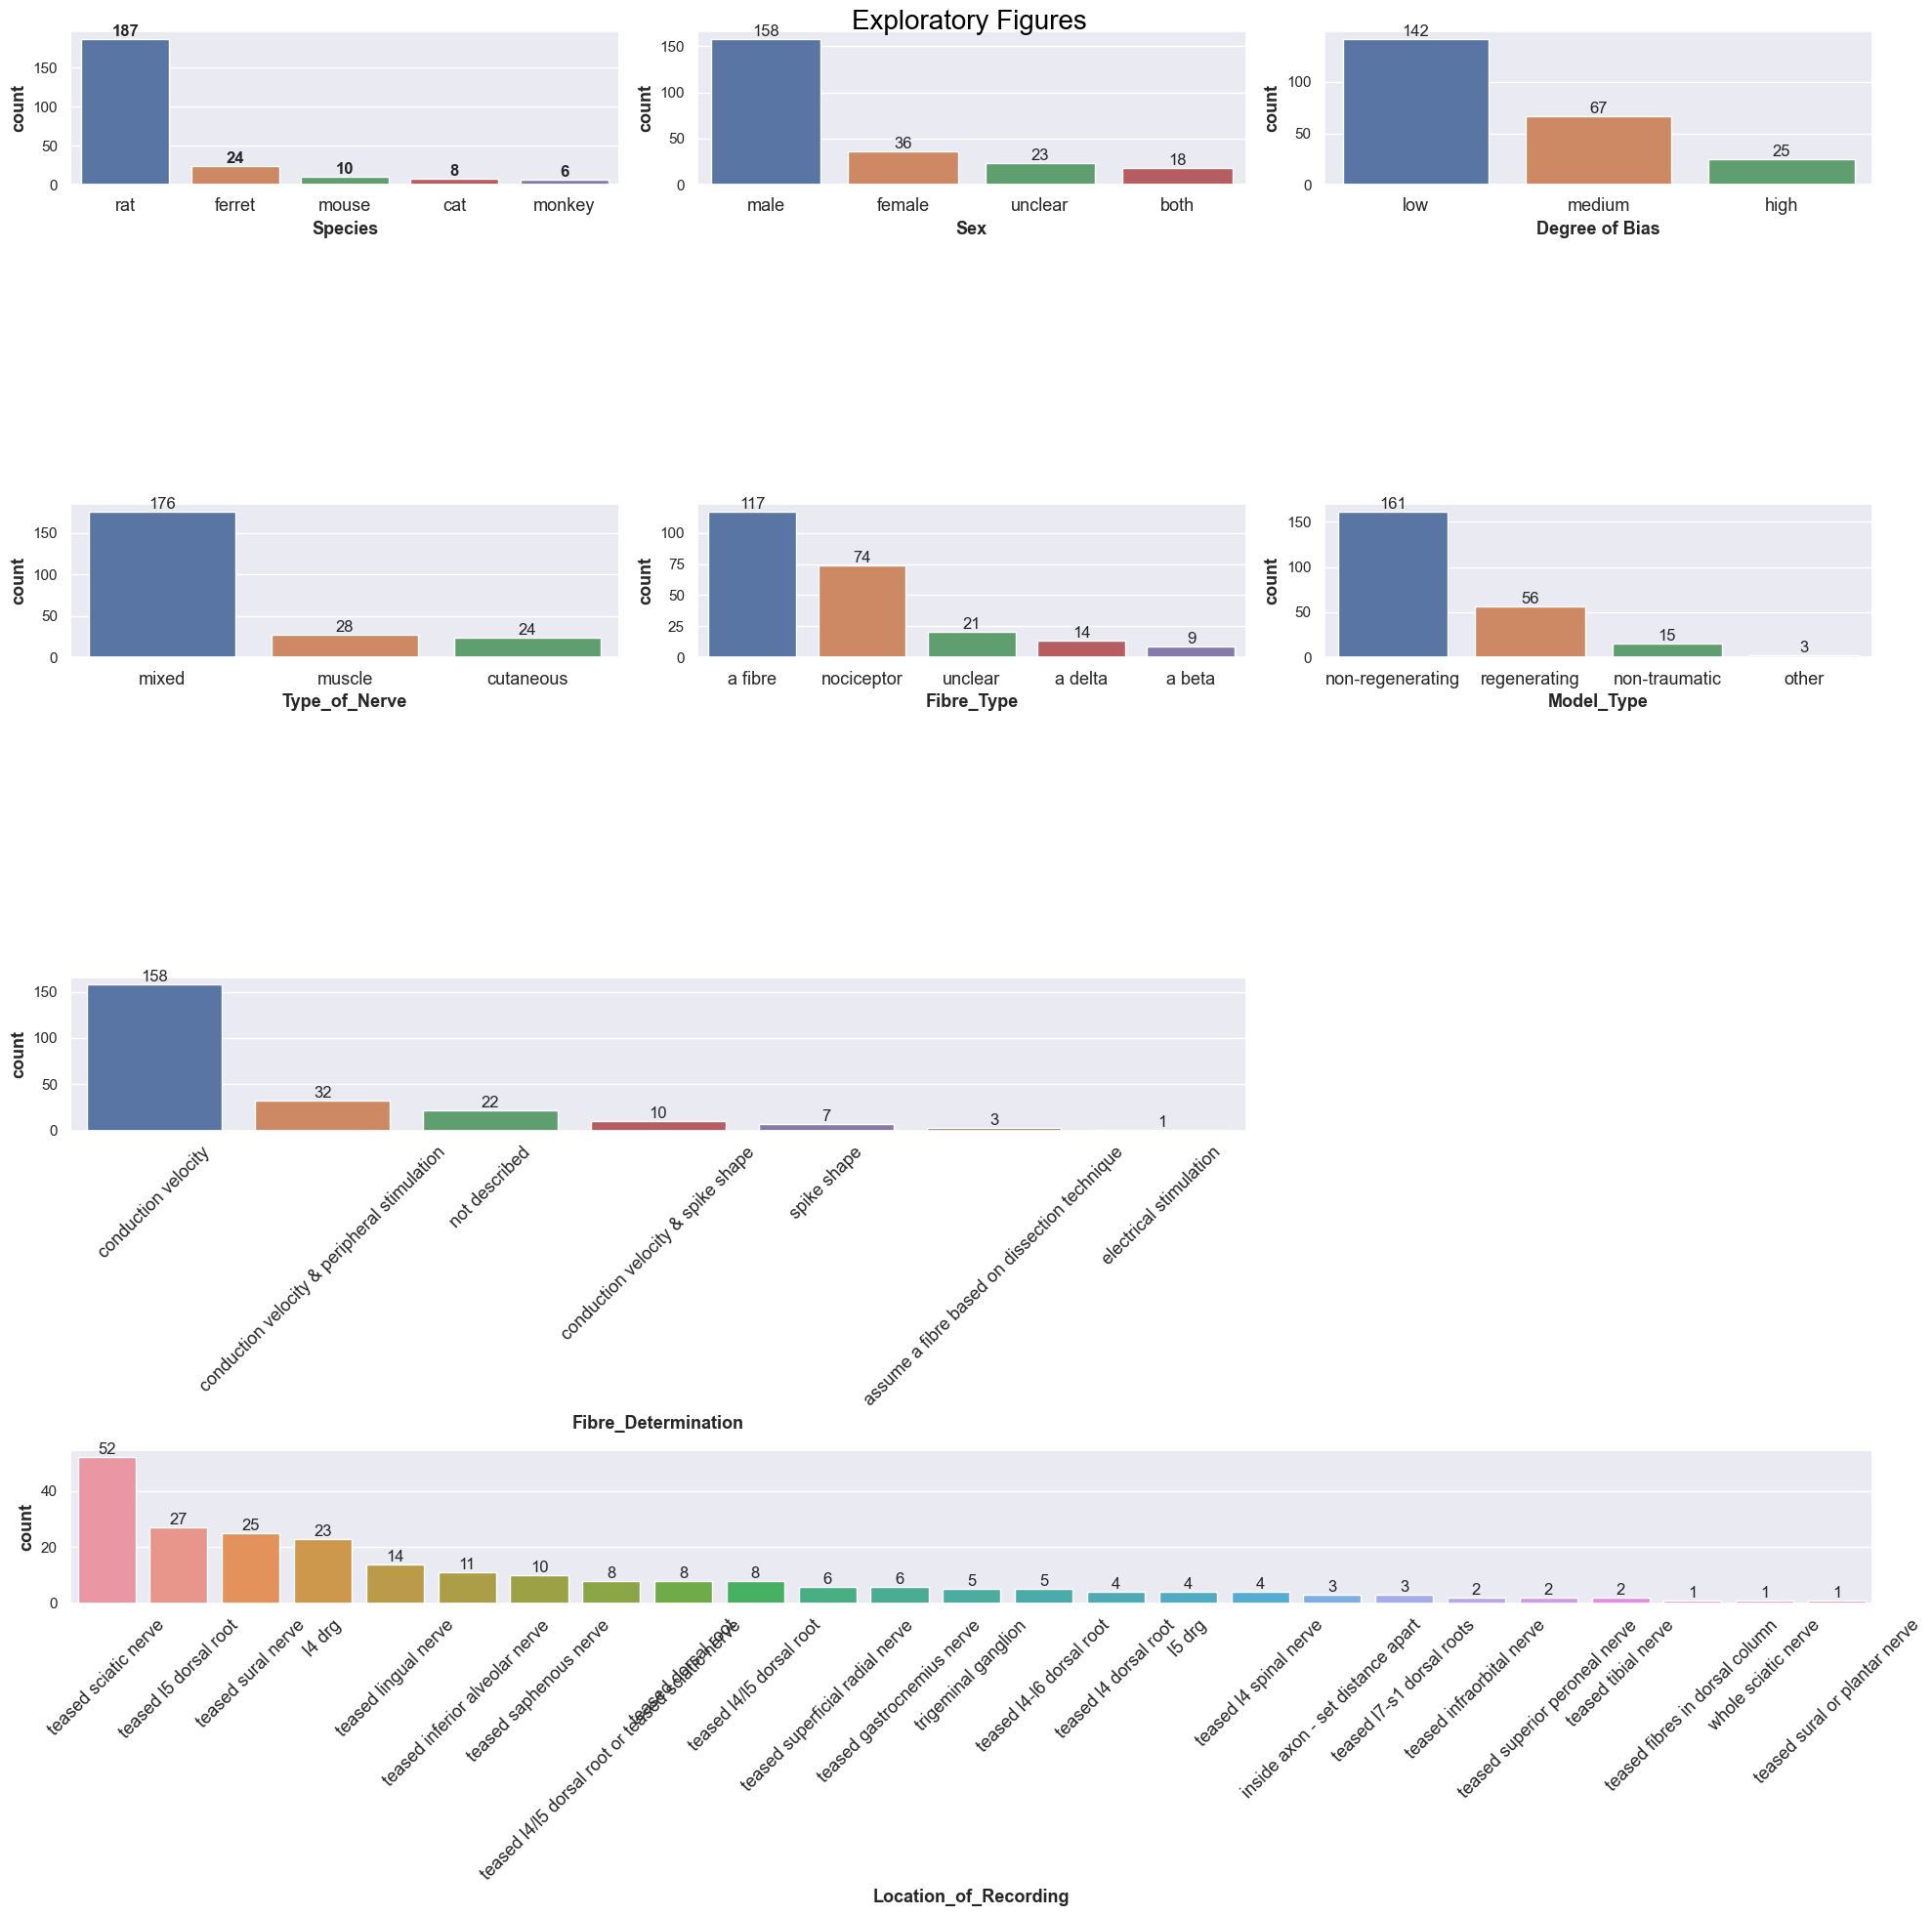

In [9]:
# Plot some explanatory data

fig = plt.figure(figsize =(20,20))
gs = fig.add_gridspec(4,3)
fig.suptitle('Exploratory Figures',fontsize = 20)
sns.set(style="darkgrid")
plt.rcParams["xtick.labelsize"] = 13
plt.rcParams["axes.labelweight"] = 'bold'
plt.rcParams["axes.labelsize"] = 13

# 1. Species Distribution (Bar)
ax1 = fig.add_subplot(gs[0,0]) 
species = non_human_df_clean['Species']
species_plot = sns.countplot(x=species, order = species.value_counts().index) 
species_plot.bar_label(species_plot.containers[0],fontweight='bold')

# 2. Sex Distribution (Bar)
ax2 = fig.add_subplot(gs[0,1]) 
sex = non_human_df_clean['Sex']
sex_dist = sns.countplot(x=sex, order = sex.value_counts().index)
sex_dist.bar_label(sex_dist.containers[0])

# 3. Degree of bias distribution (Bar)
ax3 = fig.add_subplot(gs[0,2]) 
bias_level = non_human_df_clean['Degree of Bias']    # need to fix the fourth column 'high' not being counted the same as the rest.
bias_level_dist = sns.countplot(x=bias_level, order = bias_level.value_counts().index)
bias_level_dist.bar_label(bias_level_dist.containers[0])

# 4. Nerve Types (Bar)
ax4 = fig.add_subplot(gs[1,0]) 
nerve_type = non_human_df_clean['Type_of_Nerve']
nerve_type_dist = sns.countplot(x=nerve_type, order = nerve_type.value_counts().index)
nerve_type_dist.bar_label(nerve_type_dist.containers[0])

# 5. Fibre Type  (Bar)
ax5 = fig.add_subplot(gs[1,1]) 
fibre_type = non_human_df_clean['Fibre_Type']
fibre_type_dist = sns.countplot(x=fibre_type, order = fibre_type.value_counts().index)
fibre_type_dist.bar_label(fibre_type_dist.containers[0])
fibre_type_dist.set_xticklabels(fibre_type_dist.get_xticklabels())

# 6. Model Type (Bar)
ax6 = fig.add_subplot(gs[1,2]) 
model_cat = non_human_df_clean['Model_Type']
model_type_dist = sns.countplot(x=model_cat, order = model_cat.value_counts().index)
model_type_dist.bar_label(model_type_dist.containers[0])
model_type_dist.set_xticklabels(model_type_dist.get_xticklabels())

# 7. Fibre Type Determination  (Bar)
ax7 = fig.add_subplot(gs[2,0:2]) 
fibre_type_deter = non_human_df_clean['Fibre_Determination']
fibre_type_deter_dist = sns.countplot(x=fibre_type_deter, order = fibre_type_deter.value_counts().index)
fibre_type_deter_dist.bar_label(fibre_type_deter_dist.containers[0])
fibre_type_deter_dist.set_xticklabels(fibre_type_deter_dist.get_xticklabels(),rotation=45)


# 8. Location of Recording  (Bar)
ax8 = fig.add_subplot(gs[3,:]) 
recording_loc = non_human_df_clean['Location_of_Recording']
recording_loc_dist = sns.countplot(x=recording_loc, order = recording_loc.value_counts().index)
recording_loc_dist.bar_label(recording_loc_dist.containers[0])
recording_loc_dist.set_xticklabels(recording_loc_dist.get_xticklabels(),rotation=45)

plt.tight_layout()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 235 entries, 1 to 495
Data columns (total 26 columns):
 #   Column                                                      Non-Null Count  Dtype  
---  ------                                                      --------------  -----  
 0   Journal                                                     235 non-null    object 
 1   Year                                                        235 non-null    float64
 2   Study_purpose                                               235 non-null    object 
 3   Species                                                     235 non-null    object 
 4   Sex                                                         235 non-null    object 
 5   injury_type                                                 235 non-null    object 
 6   Model_Type                                                  235 non-null    object 
 7   Which nerve/model?                                          235 non-null    object 
 8   

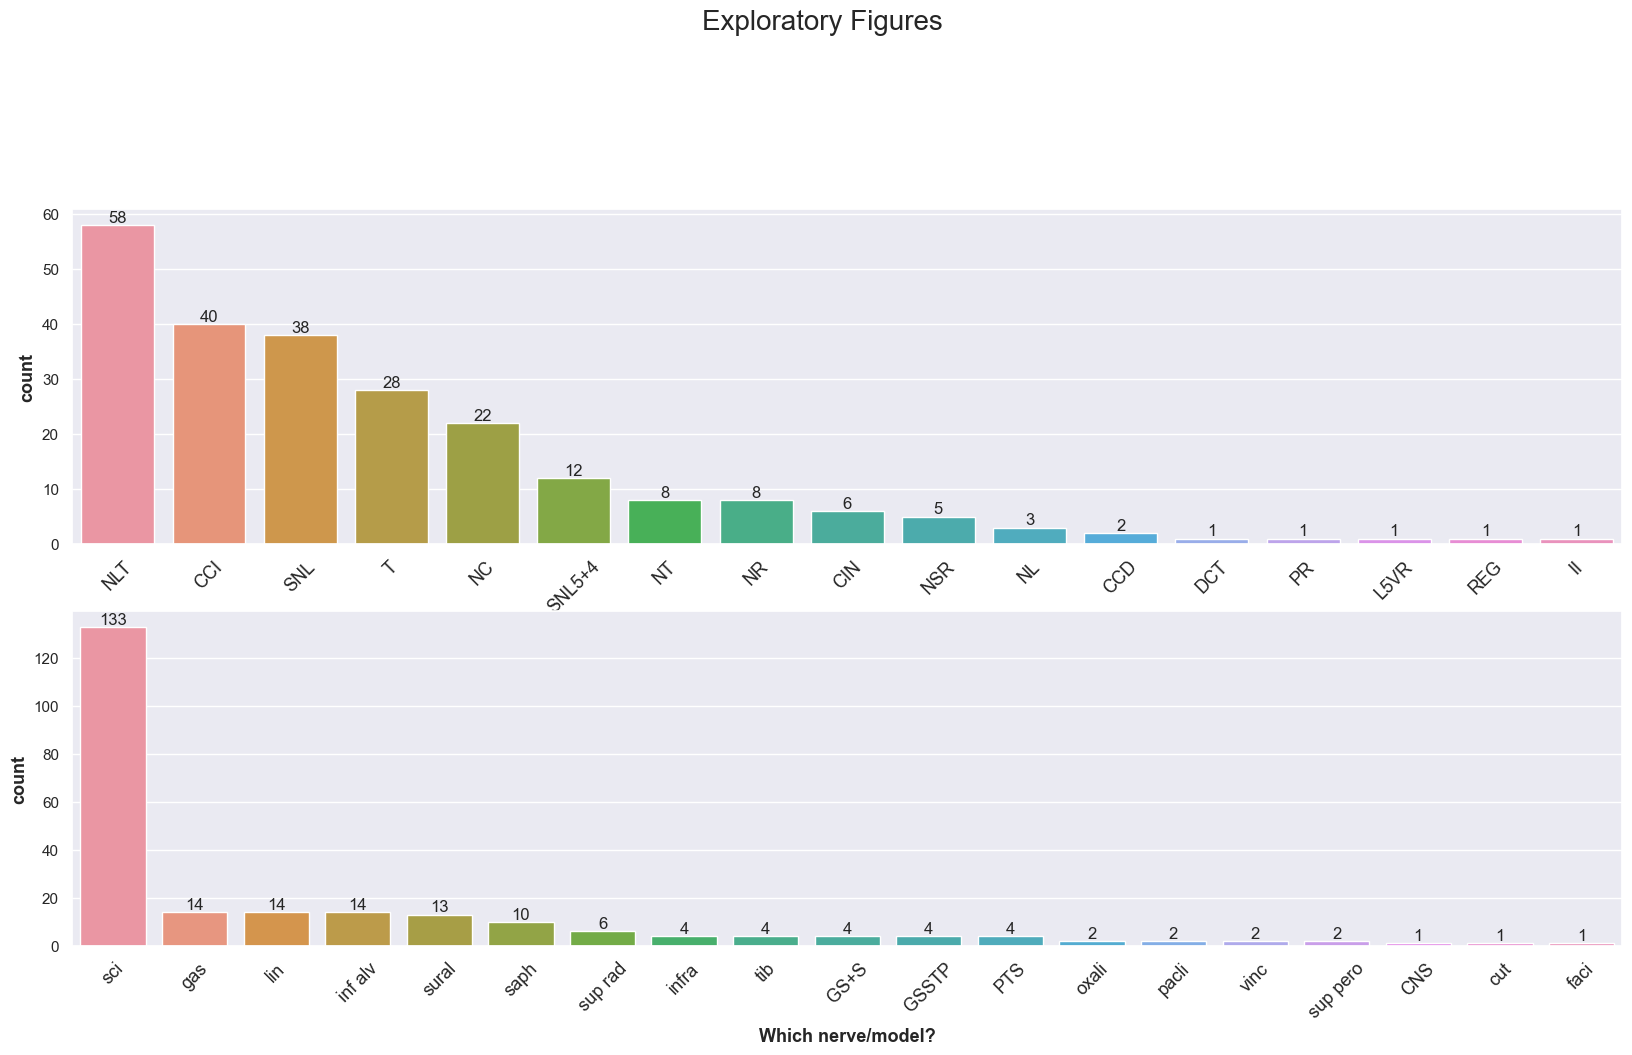

In [167]:
# Plotting the larger figures here with more space

fig = plt.figure(figsize =(20,20))
gs = fig.add_gridspec(4,4)
fig.suptitle('Exploratory Figures',fontsize = 20)
sns.set(style="darkgrid")
plt.rcParams["xtick.labelsize"] = 13
plt.rcParams["axes.labelweight"] = 'bold'
plt.rcParams["axes.labelsize"] = 13

print(non_human_df_clean.info())
# 1. Injury Type (Bar)
ax3 = fig.add_subplot(gs[0,:]) 
injury = non_human_df_clean['injury_type']
injury_dist = sns.countplot(x=injury, order = injury.value_counts().index)
injury_abbreviations= ['NLT','CCI','SNL','T','NC','SNL5+4','NT','NR','CIN','NSR','NL','CCD','DCT','PR','L5VR','REG','II']
injury_dist.set_xticklabels(labels= injury_abbreviations, rotation=45 )
injury_dist.bar_label(injury_dist.containers[0])

# 2. Model Location (Bar)
ax5 = fig.add_subplot(gs[1,:]) 
model_nerve_model = non_human_df_clean['Which nerve/model?']
model_nerve_dist = sns.countplot(x=model_nerve_model, order = model_nerve_model.value_counts().index)
model_nerve_dist.bar_label(model_nerve_dist.containers[0])
injury_model_abbreviations = ['sci','gas','lin','inf alv','sural','saph','sup rad','infra', 'tib','GS+S', 'GSSTP','PTS','oxali','pacli','vinc','sup pero','CNS', 'cut','faci']
model_nerve_dist.set_xticklabels(injury_model_abbreviations,rotation=45)

sa_injured = non_human_df_clean['% SA neurones.1']
sa_injured = non_human_df_clean['% SA neurones.1'].str.replace(',','.').astype(float)

# Null values because the authors did not report the values necessary for % calculations.

> Unfortunately, despite filtering the data using basic filters/switches, there are still many inconsistent reporting of data thus leaving empty fields in the spreadsheet. As the person collecting the data manually, I can confirm that there are useful data that can extracted even in articles that have not reported 'essential' numbers e.g. number of fibres recorded.

>Certainly, the most critical information is the % spontaneous activity in injured/non-injured nerves; however, there is indeed a great variety of combinations of null fields, where the author has not stated certain values. 

>Thus, instead of removing all rows with NaN/Null values, I propose to keep the NaN values included where the model would lose confidence per experiment based on the number of missing values. XGBoost will handle NaN values like this. For neural networks, a different approach will be required.

>This means that not all experiments will be equally weighted and spontaneous activity % values from those with the most robust reporting standards will be more influential in the overview/model than those that merely report the % spontaneous activity recorded.



To generate summary figures for the data overall, I will split the data into these main categories:

1. Species Distribution (Pie)
2. Sex Distribution (Bar)
3. Injury Type (Bar)
4. Model Type (Bar)
5. Model Location (Bar)
6. Nerve Types (Bar)
7. Earliest Recording Times (in days)  (Bar)
8. Latest Recording Times (in days)  (Bar)
9. Experiment Time Categoried  (Bar)
10. Fibre Type  (Bar)
11. Fibre Type Determination  (Bar)
12. Location of Recording  (Bar)
13. % SA in control groups vs Latest Recording Times  (Scatter)
14. % SA in injury groups vs Latest Recording Times (Scatter)
15. Degree of bias distribution  (Bar)


In [12]:
non_human_df_clean.isnull().sum() # we can see that there are null values in the dataset as I mentioned before.

Journal                                                         0
Year                                                            0
Study_purpose                                                   0
Species                                                         0
Sex                                                             0
injury_type                                                     0
Model_Type                                                      0
Which nerve/model?                                              0
Type_of_Nerve                                                   7
Ephys type                                                      0
Earliest recording (in days after intervention)                 3
Latest recording (in days after intervention)                   0
Fibre_Type                                                      0
Fibre_Determination                                             2
Location_of_Recording                                           0
n of neuro

In [13]:
# Currently, there are many NaN values 
def impute_random_nan(df,column_name,column_name_with_random):
    
    #Make copy of Column
    df[column_name_with_random]=df[column_name]
    #Select random sample value to fill the na
    # .dropna() - to ignore NAN values and select non-NAN values
    random_sample = df[column_name].dropna().sample(df[column_name].isnull().sum(),random_state=0, replace=True)

    # Merge - pandas need to have same index in order to merge the dataset.
    random_sample.index = df[df[column_name].isnull()].index
    df.loc[df[column_name].isnull(),column_name_with_random]=random_sample
    df= df.drop([column_name],axis=1)
    return df


In [14]:
def add_nan_binary_mask(df):
    df =df 
    for col in df.columns:
        if df[col].isnull().sum() > 0:
            nan_binary_mask = col + "_nan"
            df[nan_binary_mask] = np.where(df[col].isnull(),1,0)
            column_name_with_random = col + "_random"
            df = impute_random_nan(df, col,column_name_with_random)

    return df

non_human_df_clean_nan_randomised= add_nan_binary_mask(non_human_df_clean)
print(non_human_df_clean_nan_randomised.isnull().sum())

Journal                                                              0
Year                                                                 0
Study_purpose                                                        0
Species                                                              0
Sex                                                                  0
injury_type                                                          0
Model_Type                                                           0
Which nerve/model?                                                   0
Ephys type                                                           0
Latest recording (in days after intervention)                        0
Fibre_Type                                                           0
Location_of_Recording                                                0
% SA neurones.1                                                      0
Type_of_Nerve_nan                                                    0
Type_o

In [15]:
dataframe = non_human_df_clean_nan_randomised
categorical_features = ['Species','Sex','injury_type','Model_Type','Type_of_Nerve','Which nerve/model?','Ephys type','Fibre_Type','Fibre_Determination','Location_of_Recording','Degree of Bias','Journal','Year','Study_purpose']
cat_features_full_list =[] 
for feature in categorical_features:
    nan_binary_column = feature+'_nan'
    new_replaced_column = feature+'_random'
    if nan_binary_column in dataframe.columns:
        cat_features_full_list.append(nan_binary_column)
    if new_replaced_column in dataframe.columns:
        cat_features_full_list.append(new_replaced_column)
    else:
        cat_features_full_list.append(feature)

output_feature = 'Fibre_Type'
continuous_features = [features for features in dataframe if features not in cat_features_full_list]
cont_features_full_list = []
for feature in continuous_features:
    nan_binary_column = feature+'_nan'
    new_replaced_column = feature+'_random'
    if nan_binary_column in dataframe.columns:
        cont_features_full_list.append(nan_binary_column)
    if new_replaced_column in dataframe.columns:
        cont_features_full_list.append(new_replaced_column)
    else:
        cont_features_full_list.append(feature)

print(dataframe[cat_features_full_list].info())
print(dataframe[cat_features_full_list].isnull().sum())
print(dataframe[cont_features_full_list].info())
print(dataframe[cont_features_full_list].isnull().sum())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 235 entries, 1 to 495
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Species                     235 non-null    object 
 1   Sex                         235 non-null    object 
 2   injury_type                 235 non-null    object 
 3   Model_Type                  235 non-null    object 
 4   Type_of_Nerve_nan           235 non-null    int32  
 5   Type_of_Nerve_random        235 non-null    object 
 6   Which nerve/model?          235 non-null    object 
 7   Ephys type                  235 non-null    object 
 8   Fibre_Type                  235 non-null    object 
 9   Fibre_Determination_nan     235 non-null    int32  
 10  Fibre_Determination_random  235 non-null    object 
 11  Location_of_Recording       235 non-null    object 
 12  Degree of Bias_nan          235 non-null    int32  
 13  Degree of Bias_random       235 non

# The dataset now does not contain NaN values.
> Instead a column copy of the NaN containing column was made with the NaN values replaced with a random value from other samples. A column stating that random value has been attributed is created next to it.

In [16]:
# Split the data into features and label.
y = non_human_df_clean_nan_randomised['Fibre_Type']
X = non_human_df_clean_nan_randomised.drop('Fibre_Type',axis=1)

# Perform a simple logistic regression to set a baseline for accuracy
1. can I do a simple logistic regression using the continuous features?
2. can I do this with the addition of categorical features?


In [17]:
# This is just the continuous dataset
cont_dataset = dataframe[cont_features_full_list] 
target_dataset = dataframe['Fibre_Type']
X= cont_dataset
y = target_dataset

In [170]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn import preprocessing

def logistic(X, y):
    label_encoder = preprocessing.LabelEncoder()
    label_encoder.fit(y)
    y = label_encoder.transform(y) # encode the labels

    cat_encoder = preprocessing.LabelEncoder()
    encoded_X  = pd.DataFrame()
    

    for column in X.columns:
        if X[column].dtype == 'object':
            encoded_X[column] = cat_encoder.fit_transform(X[column])
        else:
            encoded_X[column] = X[column]
    
    X_train, X_test, y_train, y_test = train_test_split(encoded_X, y, random_state=42, test_size=0.2)
    lr = LogisticRegression(solver='lbfgs', max_iter=10000)
    lr.fit(X_train, y_train)
    y_pred = lr.predict(X_test)
    y_pred_decoded = label_encoder.inverse_transform(y_pred)  # decode the predicted labels
    y_test_decoded = label_encoder.inverse_transform(y_test)  # decode the target labels
    print('Accuracy : ', accuracy_score(y_test, y_pred))
    print('Confusion Matrix :\n', confusion_matrix(y_test, y_pred))

    for predicted, target in zip(y_pred_decoded, y_test_decoded):
        print("Predicted: ", predicted, " Target: ", target)

logistic(X,y)

Accuracy :  0.3617021276595745
Confusion Matrix :
 [[0 0 0 1 0]
 [1 0 4 1 0]
 [1 1 7 6 3]
 [0 0 7 8 0]
 [1 0 3 1 2]]
Predicted:  a fibre  Target:  unclear
Predicted:  nociceptor  Target:  nociceptor
Predicted:  a fibre  Target:  a fibre
Predicted:  nociceptor  Target:  nociceptor
Predicted:  unclear  Target:  unclear
Predicted:  nociceptor  Target:  a fibre
Predicted:  a fibre  Target:  a fibre
Predicted:  a beta  Target:  a delta
Predicted:  a beta  Target:  unclear
Predicted:  a beta  Target:  a fibre
Predicted:  a fibre  Target:  a delta
Predicted:  a fibre  Target:  a fibre
Predicted:  a fibre  Target:  a delta
Predicted:  nociceptor  Target:  nociceptor
Predicted:  a fibre  Target:  nociceptor
Predicted:  nociceptor  Target:  nociceptor
Predicted:  a fibre  Target:  a fibre
Predicted:  a fibre  Target:  nociceptor
Predicted:  a fibre  Target:  a delta
Predicted:  nociceptor  Target:  nociceptor
Predicted:  nociceptor  Target:  a fibre
Predicted:  nociceptor  Target:  a fibre
Predi

# Using just the continuous dataset, we can predict approximately 25% of the fibre types.
> There are 5 different classes of fibre types, with the majority as the A fibre. This likely means that there is very little improvement than if a random class was predicted.

In [169]:
# Though the accuracy is low, the logist regression is working. Now I will include my categorical features into the mix.
cont_dataset = dataframe[cont_features_full_list]
cat_dataset = dataframe[cat_features_full_list]
full_dataset = pd.concat([cont_dataset,cat_dataset],axis=1)
full_dataset = full_dataset.drop(['Fibre_Type'],axis=1)
target_dataset = dataframe['Fibre_Type']
X= full_dataset
y = target_dataset

logistic(X,y)

Accuracy :  0.3617021276595745
Confusion Matrix :
 [[0 0 0 1 0]
 [1 0 4 1 0]
 [1 1 7 6 3]
 [0 0 7 8 0]
 [1 0 3 1 2]]
Predicted:  a fibre  Target:  unclear
Predicted:  nociceptor  Target:  nociceptor
Predicted:  a fibre  Target:  a fibre
Predicted:  nociceptor  Target:  nociceptor
Predicted:  unclear  Target:  unclear
Predicted:  nociceptor  Target:  a fibre
Predicted:  a fibre  Target:  a fibre
Predicted:  a beta  Target:  a delta
Predicted:  a beta  Target:  unclear
Predicted:  a beta  Target:  a fibre
Predicted:  a fibre  Target:  a delta
Predicted:  a fibre  Target:  a fibre
Predicted:  a fibre  Target:  a delta
Predicted:  nociceptor  Target:  nociceptor
Predicted:  a fibre  Target:  nociceptor
Predicted:  nociceptor  Target:  nociceptor
Predicted:  a fibre  Target:  a fibre
Predicted:  a fibre  Target:  nociceptor
Predicted:  a fibre  Target:  a delta
Predicted:  nociceptor  Target:  nociceptor
Predicted:  nociceptor  Target:  a fibre
Predicted:  nociceptor  Target:  a fibre
Predi

# Using both continuous and categorical data for simple logistic regression, we can achieve 36% accuracy. 
This is a slight improvement from the previous model.

In [168]:
# Now that I have completed the logistic regression, I will now attempt to apply other classifiers to see if the data present in our dataset can be used to accurately predict the firbe type
# First one will be XGBoost

from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn import preprocessing

def xgboost_classifier(X, y):
    label_encoder = preprocessing.LabelEncoder()
    label_encoder.fit(y)
    y = label_encoder.transform(y) # encode the labels

    cat_encoder = preprocessing.LabelEncoder()
    encoded_X  = pd.DataFrame()
    
    for column in X.columns:
        if X[column].dtype == 'object':
            encoded_X[column] = cat_encoder.fit_transform(X[column])
        else:
            encoded_X[column] = X[column]
    
    X_train, X_test, y_train, y_test = train_test_split(encoded_X, y, random_state=42, test_size=0.2)
    xgb = XGBClassifier(se_label_encoder=False,verbosity = 0)
    xgb.fit(X_train, y_train)
    y_pred = xgb.predict(X_test)
    y_pred_decoded = label_encoder.inverse_transform(y_pred)  # decode the predicted labels
    y_test_decoded = label_encoder.inverse_transform(y_test)  # decode the target labels
    print('Accuracy : ', accuracy_score(y_test, y_pred))
    print('Confusion Matrix :\n', confusion_matrix(y_test, y_pred))

    for predicted, target in zip(y_pred_decoded, y_test_decoded):
        print("Predicted: ", predicted, " Target: ", target)

xgboost_classifier(X,y)

Accuracy :  0.44680851063829785
Confusion Matrix :
 [[ 0  0  0  1  0]
 [ 1  0  3  2  0]
 [ 1  0 12  4  1]
 [ 0  0  8  7  0]
 [ 0  0  4  1  2]]
Predicted:  a fibre  Target:  unclear
Predicted:  nociceptor  Target:  nociceptor
Predicted:  a fibre  Target:  a fibre
Predicted:  nociceptor  Target:  nociceptor
Predicted:  a fibre  Target:  unclear
Predicted:  nociceptor  Target:  a fibre
Predicted:  a fibre  Target:  a fibre
Predicted:  a beta  Target:  a delta
Predicted:  unclear  Target:  unclear
Predicted:  a beta  Target:  a fibre
Predicted:  nociceptor  Target:  a delta
Predicted:  a fibre  Target:  a fibre
Predicted:  a fibre  Target:  a delta
Predicted:  nociceptor  Target:  nociceptor
Predicted:  a fibre  Target:  nociceptor
Predicted:  a fibre  Target:  nociceptor
Predicted:  nociceptor  Target:  a fibre
Predicted:  a fibre  Target:  nociceptor
Predicted:  a fibre  Target:  a delta
Predicted:  nociceptor  Target:  nociceptor
Predicted:  a fibre  Target:  a fibre
Predicted:  nocicep

# We add a little bit more improvement to the performance 
XGBoost may require some hyperparameter tuning to achieve the optimal results.

In [172]:
# I will now use Grid Search to find the best parameters

from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')
def xgboost_classifier_gridsearch(X, y):
    label_encoder = preprocessing.LabelEncoder()
    label_encoder.fit(y)
    y = label_encoder.transform(y) # encode the labels

    cat_encoder = preprocessing.LabelEncoder()
    encoded_X  = pd.DataFrame()
    
    for column in X.columns:
        if X[column].dtype == 'object':
            encoded_X[column] = cat_encoder.fit_transform(X[column])
        else:
            encoded_X[column] = X[column]
    
    X_train, X_test, y_train, y_test = train_test_split(encoded_X, y, random_state=42, test_size=0.2)
    xgb = XGBClassifier(use_label_encoder=False,verbosity = 0)

    # Define the parameter grid for grid search
    param_grid = {'max_depth': [3, 4, 5], 'learning_rate': [0.1, 0.01, 0.001], 'n_estimators': [100, 200, 300]}

    # Create a GridSearchCV object
    grid_search = GridSearchCV(xgb, param_grid, cv=5)

    # Fit the GridSearchCV object to the data
    grid_search.fit(X_train, y_train)

    # Print the best parameters and score
    print("Best parameters: ", grid_search.best_params_)
    print("Best score: ", grid_search.best_score_)
    print("Best estimator: ", grid_search.best_estimator_)
    
    # use the best estimator to predict the test set
    y_pred = grid_search.best_estimator_.predict(X_test)
    y_pred_decoded = label_encoder.inverse_transform(y_pred)  # decode the predicted labels
    y_test_decoded = label_encoder.inverse_transform(y_test)  # decode the target labels
    print('Accuracy : ', accuracy_score(y_test, y_pred))
    print('Confusion Matrix :\n', confusion_matrix(y_test, y_pred))

    for predicted, target in zip(y_pred_decoded, y_test_decoded):
        print("Predicted: ", predicted, " Target: ", target)

xgboost_classifier_gridsearch(X,y)

Best parameters:  {'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 300}
Best score:  0.5635846372688478
Best estimator:  XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=300, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)
Accuracy :  0.5319148936170213
Confusion Matrix :
 [[ 0  0  0  1  0]
 [ 1  0  4  1  0]
 [ 1  0 14  3  0]
 [ 0  0  

# Using GridSearch we improve the performance. 
The best estimator predicted from this grid search is to use learning rate of 0.2, max depth of 3 and 300 estimators.
We still only achieve 57%. This might be because there are features included in the dataset that are not relevant for the prediction of fibre types. 
For example, the earliest day of recording post injury may not have a great influence on the fibre type predicted. 


Accuracy :  0.6197183098591549
Confusion Matrix :
 [[ 0  2  0  0  0]
 [ 0  4  1  1  0]
 [ 0  0 26  6  0]
 [ 0  1 11 10  0]
 [ 0  0  3  2  4]]
Predicted:  a fibre  Target:  unclear
Predicted:  a fibre  Target:  nociceptor
Predicted:  a fibre  Target:  a fibre
Predicted:  nociceptor  Target:  nociceptor
Predicted:  unclear  Target:  unclear
Predicted:  nociceptor  Target:  a fibre
Predicted:  a fibre  Target:  a fibre
Predicted:  nociceptor  Target:  a delta
Predicted:  unclear  Target:  unclear
Predicted:  nociceptor  Target:  a fibre
Predicted:  a delta  Target:  a delta
Predicted:  a fibre  Target:  a fibre
Predicted:  a delta  Target:  a delta
Predicted:  nociceptor  Target:  nociceptor
Predicted:  a fibre  Target:  nociceptor
Predicted:  nociceptor  Target:  nociceptor
Predicted:  a fibre  Target:  a fibre
Predicted:  nociceptor  Target:  nociceptor
Predicted:  a delta  Target:  a delta
Predicted:  a fibre  Target:  nociceptor
Predicted:  a fibre  Target:  a fibre
Predicted:  nocice

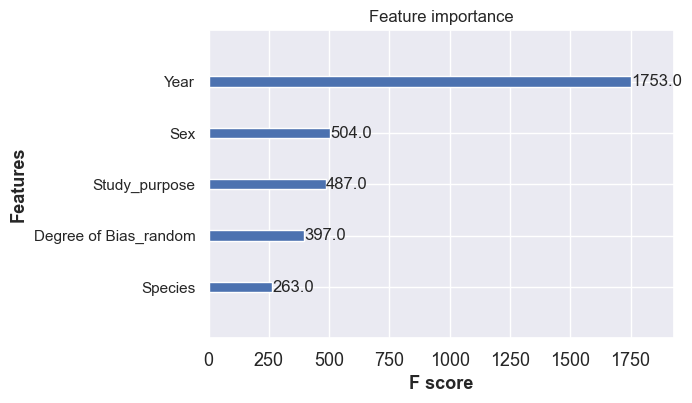

In [181]:
# Now it seems that the best score we get is 57% accuracy. 
# I will now have a look at the best features to use for predictions as it is likely that some of the features are not that relevant. 

def xgboost_classifier_selectkbest(X, y, k):
    label_encoder = preprocessing.LabelEncoder()
    label_encoder.fit(y)
    y = label_encoder.transform(y) # encode the labels

    cat_encoder = preprocessing.LabelEncoder()
    encoded_X  = pd.DataFrame()

    for column in X.columns:
        if X[column].dtype == 'object':
            encoded_X[column] = cat_encoder.fit_transform(X[column])
        else:
            encoded_X[column] = X[column]
    
    X_train, X_test, y_train, y_test = train_test_split(encoded_X, y, random_state=42, test_size=0.3)
    xgb = XGBClassifier()
    xgb.fit(X_train, y_train)

    # Use the built-in feature selection method
    xgb.feature_importances_
    model = SelectFromModel(xgb, threshold=0.05)
    feature_idx = model.get_support()
    feature_name = X_train.columns[feature_idx]
    model.fit(X_train, y_train)
    X_train_new = model.transform(X_train)
    X_test_new = model.transform(X_test)

    # Select the best K features using SelectKBest
    selector = SelectKBest(f_classif, k='all')
    selector.fit(X_train_new, y_train)
    X_train_new = selector.transform(X_train_new)
    X_test_new = selector.transform(X_test_new)
    X_train_df = pd.DataFrame(X_train_new, columns= feature_name)
    X_test_df = pd.DataFrame(X_test_new, columns = feature_name)

    # xgb = XGBClassifier()
    xgb.fit(X_train_df, y_train)
    # y_pred = xgb.predict(X_test)
    y_pred = xgb.predict(X_test_df)
    y_pred_decoded = label_encoder.inverse_transform(y_pred)  # decode the predicted labels
    y_test_decoded = label_encoder.inverse_transform(y_test)  # decode the target labels
    print('Accuracy : ', accuracy_score(y_test, y_pred))
    print('Confusion Matrix :\n', confusion_matrix(y_test, y_pred))

    for predicted, target in zip(y_pred_decoded, y_test_decoded):
        print("Predicted: ", predicted, " Target: ", target)

    plot_importance(xgb)
    dict2 =xgb.get_booster().get_score(importance_type= 'weight')
    print(dict2)
xgboost_classifier_selectkbest(X, y, 'all')

# Feature selection improves performance.
Using a combination of SelectFromModel and SelectKBest, the features of highest importance were selected beyond a threhsold. It returns that 5 features are important with significant emphasis on the year that the experiment was conducted. Before making any concrete conclusions, we will compare the distribution of each feature against the fibre type. 

In [29]:
# This is interesting. Let's have a look at these data points and compare it! 

# Year vs Fibre Type
# Sex vs Fibre Type
# Study Purpose vs Fibre Type
# Degree of Bias_random vs Fibre Type
# Species vs Fibre Type

In [30]:
# Create a dataframe containing the year as the number of rows # and Fibre Types Grouped for each year
sns.set_theme(style="whitegrid")

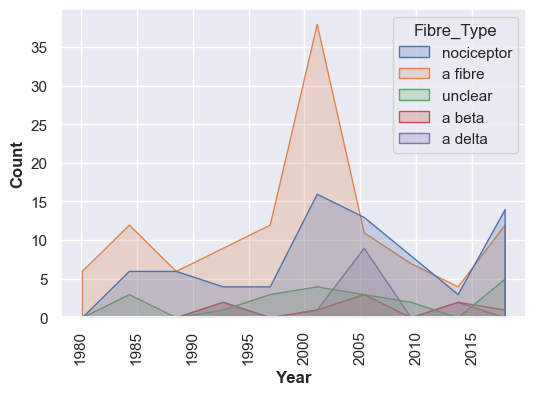

In [31]:
year = X['Year']
fibre_type = y
year_and_fibre_type = pd.concat([year,fibre_type],axis=1)
year_and_fibre_type.sort_values('Year', ascending=False).head(50)
# sns.histoplot(x=year_and_fibre_type["Year"])
sns.set(rc={'figure.figsize':(6,4)})
chart = sns.histplot(data = year_and_fibre_type, x="Year", hue = "Fibre_Type", element="poly")
chart.set_xticklabels(chart.get_xticklabels(),rotation=90)
None

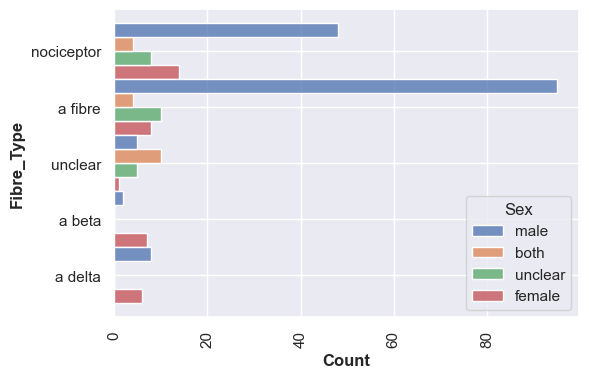

In [32]:
year = X['Sex']
fibre_type = y
year_and_fibre_type = pd.concat([year,fibre_type],axis=1)
year_and_fibre_type.sort_values('Sex', ascending=False).head(50)
# sns.histoplot(x=year_and_fibre_type["Year"])
sns.set(rc={'figure.figsize':(6,4)})
chart = sns.histplot(data = year_and_fibre_type, y="Fibre_Type", hue = "Sex",multiple="dodge")
chart.set_xticklabels(chart.get_xticklabels(),rotation=90)
None

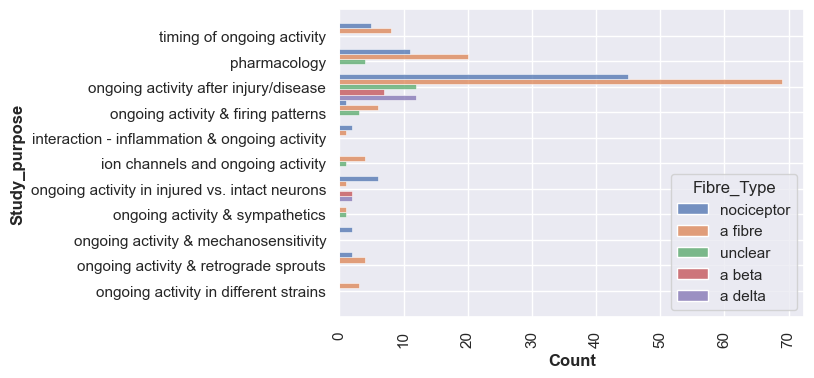

In [33]:
year = X['Study_purpose']
fibre_type = y
year_and_fibre_type = pd.concat([year,fibre_type],axis=1)
year_and_fibre_type.sort_values('Study_purpose', ascending=False).head(50)
# sns.histoplot(x=year_and_fibre_type["Year"])
sns.set(rc={'figure.figsize':(6,4)})
chart = sns.histplot(data = year_and_fibre_type, y="Study_purpose", hue = "Fibre_Type",multiple="dodge")
chart.set_xticklabels(chart.get_xticklabels(),rotation=90)
None

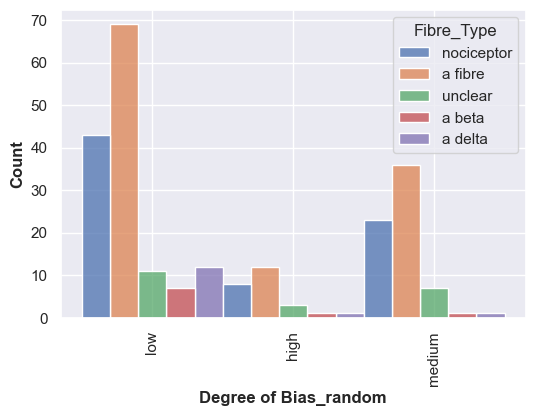

In [34]:
year = X['Degree of Bias_random']
fibre_type = y
year_and_fibre_type = pd.concat([year,fibre_type],axis=1)
year_and_fibre_type.sort_values('Degree of Bias_random', ascending=False).head(50)
# sns.histoplot(x=year_and_fibre_type["Year"])
sns.set(rc={'figure.figsize':(6,4)})
chart = sns.histplot(data = year_and_fibre_type, x='Degree of Bias_random', hue = "Fibre_Type",multiple="dodge")
chart.set_xticklabels(chart.get_xticklabels(),rotation=90)
None

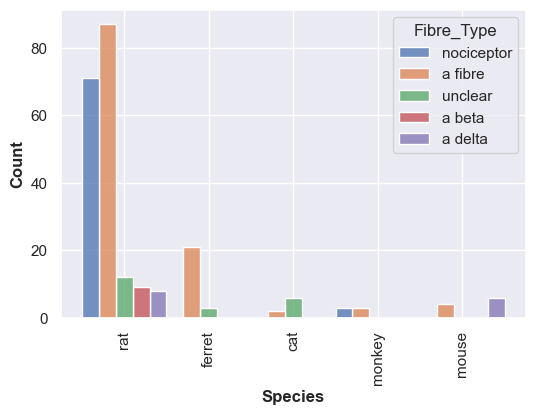

In [35]:
year = X['Species']
fibre_type = y
year_and_fibre_type = pd.concat([year,fibre_type],axis=1)
year_and_fibre_type.sort_values('Species', ascending=False).head(50)
# sns.histoplot(x=year_and_fibre_type["Year"])
sns.set(rc={'figure.figsize':(6,4)})
chart = sns.histplot(data = year_and_fibre_type, x='Species', hue = "Fibre_Type",multiple="dodge")
chart.set_xticklabels(chart.get_xticklabels(),rotation=90)
None

# Conclusions

Based on our simple data analysis, we discovered a somewhat interesting pattern where the year of publication is a critical factor to predicting the fibre type. When plotting the fibre types against the year of publication, there is indeed a distinct ratio asymmetry. Before 2010, A fibres were much more prevalent than C-fibre recordings but beyond this timepoint, the ratio was relatively even. This is not too surprising as it is well known in the field that C-fibres are generally harder to detect/record and are also prone to sensitiisation from continuous stimulation (which should mean the sample will be cut short). Thus, a possible explanation for this trend is that as electrophysiology technoloiges and knowledge improve over time, there are more successful experiments. Overall, it is true that there is a significant drop in the interest on spontaneous activity in general but there does seem to be a resurgence of experiments on the topic. 

For the remaining features (Sex, Study Purpose, Degree of Bias and Species), which were all marked as less than a third important to the publication year, show no distinct pattern between fibre types; however, there is a component that is universal in these features - they have subcategories that have very few numbers of samples, which obviously presents a problem of sampling bias. For example, if the model predicts the fibre type on data from a monkey, then the there is 50% chance the fibre will be a nociceptor or a fibre. The other features are omitted as a result of absence of data in the training set. Given that the number of studies in these smaller categories are smaller than the number of possible fibre types, gives us no confidence that the data is a representative sample of the population and thus any predictions from these features are likely to introduce bias.  

Therefore, while the year of publication is likely a good indicator to what fibre type the study was on, practically, this has no signficant utility. Or at least, the maximum accuracy will be limited to approximately a single feature analysis based on year and fibre type. While on the other hand, there is a problem highlighted with the other features where either 1) the dataset contains significantly undersampled subcategories and can skew the prediction weights or 2) there are too many variations for the number of publications in total. 

Overall, more studies need to be conducted on spontaneous activity, and perhaps going against the grain of publication culture, we must push to conduct repeats of experiments by other independent groups, especially of those that are under-represented (e.g. monkey studies), as they may hold the key information that could further our knowledge of spontaneous activity. 

# Building a neural network that can predict the fibre type of the experiment.



In [186]:
import torch
from torch.utils.data import Dataset, DataLoader 
from sklearn.preprocessing import LabelEncoder
from pytorch_lightning import LightningDataModule, Trainer
from pytorch_lightning.core import LightningModule
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
from sklearn import preprocessing

def le_dataset(X,y):
    label_encoder = preprocessing.LabelEncoder()
    label_encoder.fit(y)
    y = label_encoder.transform(y) # encode the labels

    cat_encoder = preprocessing.LabelEncoder()
    encoded_X  = pd.DataFrame()

    for column in X.columns:
        if X[column].dtype == 'object':
            encoded_X[column] = cat_encoder.fit_transform(X[column])
        else:
            encoded_X[column] = X[column]
    return encoded_X,y

features, labels = le_dataset(X,y)

class CustomDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = torch.tensor(labels)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        feature = torch.as_tensor(self.features[idx], dtype=torch.float32)
        label = torch.as_tensor(self.labels[idx], dtype=torch.float32)
        return feature, label


class CustomModel(LightningModule):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr= 1e-3)
        return optimizer

    def training_step(self, train_batch, batch_idx):
        x, y = train_batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y.long())
        accuracy = torch.mean(torch.eq(y_hat.argmax(1), y).float())
        self.log('train_loss', loss)
        self.log('train_accuracy', accuracy)
        tensorboard_logs = {'train_loss': loss, 'train_accuracy': accuracy}
        # use key 'log'
        return {"loss": loss, 'log': tensorboard_logs}
   

    def validation_step(self, val_batch, batch_idx):
        x, y = val_batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)
        return {'val_loss': loss, 'y_hat': y_hat, 'y': y}

    def validation_end(self, outputs):
        avg_loss = torch.stack([x['val_loss'] for x in outputs]).mean()
        correct = 0
        total = 0
        for i in range(len(outputs)):
            correct += torch.sum(torch.eq(outputs[i]['y_hat'].argmax(1), outputs[i]['y'])).item()
            total += outputs[i]['y'].size(0)
        accuracy = correct / total
        self.log('val_accuracy', accuracy)
        tensorboard_logs = {'avg_val_loss': avg_loss, 'val_accuracy': accuracy}
        # use key 'log'
        return {'val_loss': avg_loss, 'val_accuracy': accuracy, 'log': tensorboard_logs}

    def test_step(self, test_batch, batch_idx):
        x, y = test_batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y.long())
        return {'test_loss': loss, 'y_hat': y_hat.long(), 'y': y.long()}
    
    def test_end(self, outputs):
        avg_loss = torch.stack([x['test_loss'] for x in outputs]).mean()
        correct = 0
        total = 0
        for i in range(len(outputs)):
            correct += torch.sum(torch.eq(outputs[i]['y_hat'], outputs[i]['y'])).item()
            total += outputs[i]['y'].size(0)
        accuracy = correct / total
        self.log('test_accuracy', accuracy)
        tensorboard_logs = {'avg_test_loss': avg_loss, 'test_accuracy': accuracy}
        return {'test_loss': avg_loss, 'test_accuracy': accuracy, 'log': tensorboard_logs}

data_train, data_val_test, labels_train, labels_val_test = train_test_split(features, labels, test_size=0.2, random_state=42)
data_val, data_test, labels_val, labels_test = train_test_split(data_val_test, labels_val_test, test_size = 0.5, random_state=42)
labels_train = torch.from_numpy(labels_train)
labels_val = torch.from_numpy(labels_val)
labels_test = torch.from_numpy(labels_test)
dataset_train = CustomDataset(data_train.to_numpy(), labels_train)
dataset_val = CustomDataset(data_val.to_numpy(), labels_val)
dataset_test = CustomDataset(data_test.to_numpy(),labels_test)
train_loader = DataLoader(dataset_train, batch_size=32,drop_last=True, shuffle= True)
val_loader = DataLoader(dataset_val, batch_size=32,drop_last=True, shuffle =False)
test_loader = DataLoader(dataset_test, batch_size=32,drop_last=True, shuffle =False)

# Hyperparameters
num_epochs = 10000

# Initialize model
model = CustomModel(input_dim= data_train.shape[1], hidden_dim= 128, output_dim= len(set(labels_train)))

# Initialize trainer
trainer = Trainer(max_epochs=num_epochs, auto_lr_find=True,profiler="simple")

# Fit model
trainer.fit(model, train_loader, val_loader)

# Test model
trainer.test(model, dataloaders = test_loader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name | Type   | Params
--------------------------------
0 | fc1  | Linear | 4.5 K 
1 | fc2  | Linear | 24.3 K
--------------------------------
28.7 K    Trainable params
0         Non-trainable params
28.7 K    Total params
0.115     Total estimated model params size (MB)


Epoch 9999: 100%|██████████| 5/5 [00:00<00:00, 86.21it/s, loss=0.00151, v_num=3] 

`Trainer.fit` stopped: `max_epochs=10000` reached.


Epoch 9999: 100%|██████████| 5/5 [00:00<00:00, 74.63it/s, loss=0.00151, v_num=3]


FIT Profiler Report

-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Action                                                                                                                                                                                         	|  Mean duration (s)	|  Num calls      	|  Total time (s) 	|  Percentage %   	|
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Total                                                                                                

[]

In [185]:
from tensorboard import notebook
notebook.list() 
notebook.display(port=6006, height=500) 

Known TensorBoard instances:
  - port 6006: logdir lightning_logs/ (started 16:18:21 ago; pid 18076)
Selecting TensorBoard with logdir lightning_logs/ (started 16:18:21 ago; port 6006, pid 18076).
